# Realtime Face Emotion Recognition

> Original Video = [link](https://www.youtube.com/watch?v=avv9GQ3b6Qg&t)

We will display only seven classess:

* 0: Angry

* 1: Disgusting

* 2: Fear

* 3: Happy

* 4: Sad

* 5: Surprised

* 6: Neutral

> Dataset: [FER2013](https://www.kaggle.com/msambare/fer2013)

*I can't use the original dataset because it was too big*

If you follow this repo, perhaps you can edit my resized dataset [here](https://drive.google.com/file/d/13rjew4Ny56bNBJs0U707eJ6A05Xez0tr/view?usp=sharing)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

In [2]:
example = cv2.imread('data/train/0/Training_33331.jpg')

In [3]:
example.shape # (height, width, type) ==> type= = RGB

(48, 48, 3)

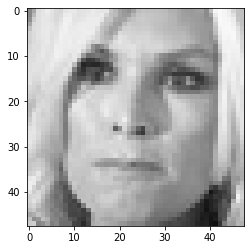

In [4]:
plt.imshow(example)

In [5]:
train_dir = 'data/train/' # Training Dataset

In [6]:
classes = ['0', '1', '2', '3', '4', '5', '6'] # List classes ==> Exact same with the directory

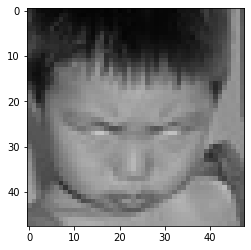

In [7]:
for category in classes:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break


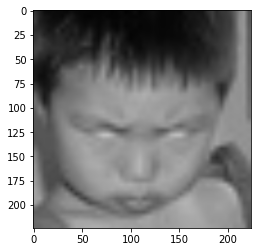

In [8]:
img_size = 224 ## ImageNet => 224 x 224
new_img = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_img.shape

(224, 224, 3)

For using Transfer Learning, we should turn the image shape as same with the algorithm

In this case is 224 x 224

## Read All Images and Convert Into Array

In [10]:
data_train = []

def create_data_train():
    for category in classes:
        path = os.path.join(train_dir, category)
        num_class = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_img = cv2.resize(img_array, (img_size, img_size))
                data_train.append([new_img, num_class])
            except Exception as e:
                pass

In [11]:
create_data_train()

In [12]:
print(len(data_train))

10000


In [13]:
temp = np.array(data_train)

<ipython-input-13-d8c78d20494a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp = np.array(data_train)


In [14]:
temp.shape

(10000, 2)

#### Our Focus is just training and deploying for real time webcam demo

In [15]:
import random

random.shuffle(data_train)

In [16]:
X = [] # data/feature
y = [] # label

for features, label in data_train:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3) # Converting it to 4 dimensions

In [17]:
X.shape

(10000, 224, 224, 3)

In [18]:
# Normalize the Data

X = X/255

In [19]:
y[0]

0

In [20]:
y.shape

AttributeError: 'list' object has no attribute 'shape'

As you can see, the interpreter is error, because it's a list. And list doesn't have any shape. Let's turn it 

In [21]:
type(y)

list

In [22]:
y = np.array(y)

In [23]:
y.shape

(10000,)

## Deep Learning model for Transfer Learning

In [24]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [25]:
model = tf.keras.applications.MobileNetV2() # Pre-Trained Model

In [26]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Transfer Learning - Tuning Process

In [27]:
base_input = model.layers[0].input

In [28]:
base_output = model.layers[-2].output

In [29]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [30]:
final_output = layers.Dense(128)(base_output)  # Adding new layer, after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) # Activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7,activation='softmax')(final_output) # Differ it into 7 classess

In [31]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [32]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [33]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Total params: 2,430,663
Trainable params: 2,396,551
Non-trainable params: 34,112
__________________________________________________________________________________________________


In [34]:
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the Model

In [35]:
new_model.fit(X,y, epochs=20)

Epoch 1/20
313/313 [==============================] - 968s 3s/step - loss: 1.4629 - accuracy: 0.4345
Epoch 2/20
313/313 [==============================] - 967s 3s/step - loss: 1.2585 - accuracy: 0.5212
Epoch 3/20
313/313 [==============================] - 986s 3s/step - loss: 1.1355 - accuracy: 0.5690
Epoch 4/20
313/313 [==============================] - 1001s 3s/step - loss: 1.0637 - accuracy: 0.5971
Epoch 5/20
313/313 [==============================] - 994s 3s/step - loss: 0.9735 - accuracy: 0.6388
Epoch 6/20
313/313 [==============================] - 1003s 3s/step - loss: 0.9071 - accuracy: 0.6606
Epoch 7/20
313/313 [==============================] - 1006s 3s/step - loss: 0.8501 - accuracy: 0.6856
Epoch 8/20
313/313 [==============================] - 1001s 3s/step - loss: 0.7789 - accuracy: 0.7110
Epoch 9/20
313/313 [==============================] - 1010s 3s/step - loss: 0.7174 - accuracy: 0.7354
Epoch 10/20
313/313 [==============================] - 1008s 3s/step - loss: 0.6478 - 

## Saving the Model

In [36]:
new_model.save('face_model_2306.h5')

C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Loading the Model

In [37]:
new_model = tf.keras.models.load_model('face_model_2306.h5')

## Accuracy 

In [38]:
new_model.evaluate 

<bound method Model.evaluate of <tensorflow.python.keras.engine.functional.Functional object at 0x00000161466DBB20>>

In [39]:
frame = cv2.imread('random_test/test1.jpg')

In [40]:
frame.shape

(400, 400, 3)

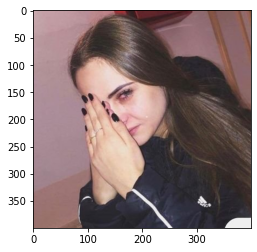

In [42]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

It must be in gray image

In [44]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [45]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [46]:
gray.shape

(400, 400)

In [47]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print('Face not detected')
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex: ex+ew]

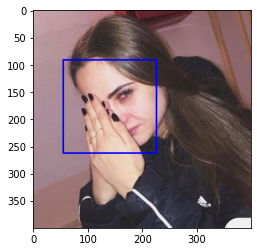

In [48]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

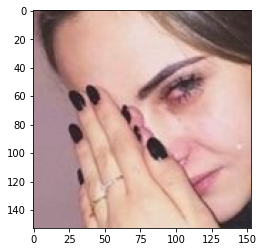

In [49]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [50]:
final_frame = cv2.resize(face_roi, (224, 224))
final_frame = np.expand_dims(final_frame, axis = 0)
final_frame = final_frame/255

In [51]:
predict_frame = new_model.predict(final_frame)

In [52]:
predict_frame[0]

array([9.9853301e-01, 8.2773738e-08, 3.7638820e-05, 5.4816675e-05,
       7.4899930e-05, 1.2992857e-03, 3.4485737e-07], dtype=float32)

In [53]:
np.argmax(predict_framerame)

0

## Conclusion

Well it still not right --- or perhaps it's not wrong but just not right enough

Maybe the prediction is 0 (angry), because when somebody cry it has anger to another

Hahaha, jokes. Okay I think enough for today, It took almost 5-7 hours for training

My laptop need a rest :)

Tomorrow, let's implement it in the webcam

## Note

You will need the model to follow the next day -- The model will be uploaded in tomorrow repository

If your laptop is not enough to build by yourself, just reduce the amount of the picture

Thanks For following until here